In [ ]:
import requests
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import bs4
from pycoingecko import CoinGeckoAPI
from collections import Counter
import matplotlib as mpl

cg = CoinGeckoAPI()

In [7]:
exchange_list = cg.get_exchanges_id_name_list()

## Derivatives CEX

- Binance | id: binance_futures
- BitMex | id: bitmex
- FTX | id: ftx
- OKEX | id: okex_swap
- Huobi Futures | id: huobi_dm
- ByBit | id: bybit
- Kraken | id: kraken_futures
- BitFinex | id: bitfinex_futures
- Deribit | id: deribit
- KuCoin | id: kumex

In [9]:
def get_all_versions (exchange):
    
    exchange_list = cg.get_exchanges_id_name_list()
    
    bool_ = []
    for i in range(len(exchange_list)):
        bool_.append(exchange in exchange_list[i]['id'])   
    
    list_ = np.array(exchange_list)[np.array(bool_)]
    
    final = []
    
    for i in range(len(list_)):
        final.append (list_[i]['id'])
    
    return final

In [10]:
def get_volume_cg (exchange, days):
    
    data = cg.get_exchanges_volume_chart_by_id (id = exchange, days = days)

    date = []
    volume = []

    for i in range(len(data)):
        date_raw = (dt.datetime.fromtimestamp((data[i][0])/1000))
        date.append(dt.datetime(date_raw.year, date_raw.month, date_raw.day))
        volume.append(float(data[i][1]))
        
    return pd.DataFrame(data = volume, index = date, columns=[exchange])

In [196]:
def save_pdf(figure_, title, xlabel, ylabel, figsize = (16, 10)):
    plt.figure(figsize = figsize)
    figure_.plot(title=title, linestyle = 'solid')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(title + '.pdf')

In [197]:
derivative_CEX = ['binance_futures', 'bitmex', 'ftx', 'okex_swap', 'huobi_dm', 'bybit', 'kraken_futures', 'bitfinex_futures', 'deribit', 'kumex']

In [198]:
days = 360 * 3

In [ ]:
### *** make it smoother so that it doesn't cancel the loop if the error shows up


df = {}

for i in range(len(derivative_CEX)):
    df[i] = get_volume_cg(derivative_CEX[i], days)

In [ ]:
def dict_to_df (dict_):
    
    data = df[0].combine_first(df[1])

    for i in range(2, len(df)):
        data = data.combine_first(df[i])
        
    return data

In [ ]:
der_CEX = dict_to_df(df)
der_CEX = der_CEX.drop_duplicates()

In [216]:
def get_BTC_price (start, end):
    
    btc = get_data_start_to_end('bitcoin', start = start, end = end)
    btc.index = pd.to_datetime(btc.index.date)
    
    return btc

## USD Nominated

In [217]:
def USD_nominate (table):
    table = table.drop_duplicates()

    btc = get_BTC_price (table.index[0], table.index[-1] + dt.timedelta(days=1))
    
    table = table[table.index <=btc.index[-1]]
    btc = btc.loc[table.index] #cleaning 
    
    table_usd = pd.DataFrame (table.values * btc.values, columns=table.columns, index = table.index)  
    
    return table_usd

In [ ]:
der_CEX_usd = USD_nominate(der_CEX)

In [ ]:
save_pdf((der_CEX_usd.sum(axis=1) / 1000000000), title = "Top 10 CEX Derivative Volume", xlabel="Time", ylabel="$ Billions")

## Derivatives DEX
- dydx
- futureswap
- perpetual_protocol

In [ ]:
DEX_derivatives = ['dydx_perpetual', 'futureswap', 'perpetual_protocol']

days = 360

df = {}

for i in range(len(DEX_derivatives)):
    df[i] = get_volume_cg(DEX_derivatives[i], days)
    
der_DEX = dict_to_df(df)

In [ ]:
der_DEX_usd = USD_nominate(der_DEX)

In [ ]:
der_DEX.sum(axis=1).plot()

In [ ]:
save_pdf(der_DEX_usd / 1000000, "Derivative DEXes Daily Volume", "Time", "$ Millions", figsize=(16, 10))

In [253]:
relative_pct = ((der_DEX.sum(axis=1) / der_CEX.sum(axis=1)) * 100)[-150:]

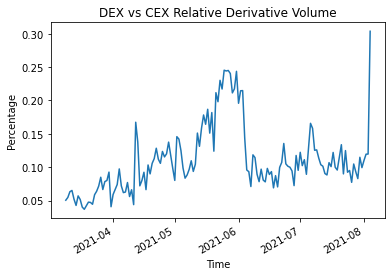

In [254]:
save_pdf(relative_pct, 'DEX vs CEX Relative Derivative Volume', 'Time', 'Percentage')

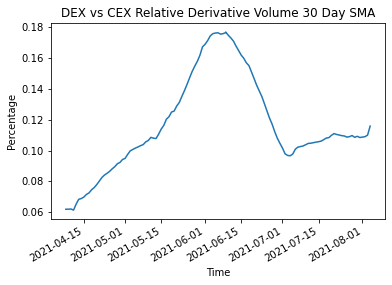

In [255]:
save_pdf(relative_pct.rolling(window=30).mean()[30:], 'DEX vs CEX Relative Derivative Volume 30 Day SMA', 'Time', 'Percentage')

In [272]:
der_DEX ['Total'] = der_DEX.sum(axis=1)

In [291]:
der_DEX = der_DEX.drop_duplicates()

In [299]:
avg = pd.DataFrame(data=[der_DEX.iloc[:, 0] / der_DEX['Total'], der_DEX.iloc[:, 1] / der_DEX['Total'], der_DEX.iloc[:, 2] / der_DEX['Total']], index=['dYdX', 'Futureswap', 'Perpetual']).T

<Figure size 432x288 with 0 Axes>

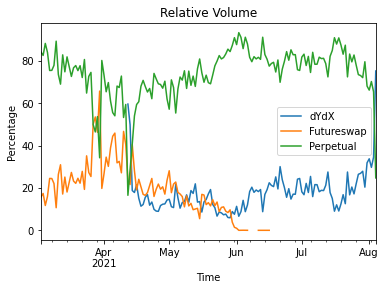

In [306]:
save_pdf(avg[30:] * 100, title = 'Relative Volume', xlabel='Time', ylabel='Percentage')

## Spot Market CEX

In [318]:
spot_CEX = ["binance", "gdax", "ftx_spot", "ftx_us", "bitmart", "kraken", "bitfinex", "binance_us", "huobi", "okex", "bitcoin_com", "kucoin"]
spot_DEX = ["uniswap", "uniswap_v2", "pancakeswap", "sushiswap", "quickswap", "bancor", "kyber_network", "dodo", "dodo_bsc", "balancer", "balancer_v1", "curve", "pangolin", "tokenlon"]

In [319]:
def get_data_for_list (list_, days):

    df = {}

    for i in range(len(list_)):
        df[i] = get_volume_cg(list_[i], days)

    volumes = df[0].combine_first(df[1])

    for i in range(2, len(df)):
        volumes = volumes.combine_first(df[i])
            
    return volumes 

In [345]:
for i in range(len(spot_CEX)):
    df[i] = get_volume_cg(spot_CEX[i], days)

volumes = df[0].combine_first(df[1])

for i in range(2, len(df)):
    volumes = volumes.combine_first(df[i])

In [346]:
## spot_CEX_volume = get_data_for_list(spot_CEX, days)    HARD TO EXECUTE; TOO MANY API ERRORS; HAD TO DO IT MANUALLY ONE BY ONE

In [347]:
spot_CEX_volume = volumes

In [349]:
spot_CEX_usd = USD_nominate(spot_CEX_volume)

<AxesSubplot:>

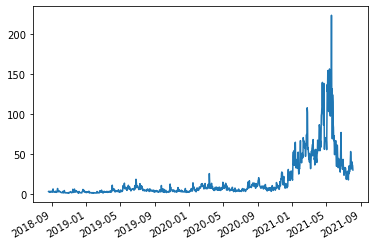

In [350]:
(spot_CEX_usd.sum(axis=1) / 1000000000).plot()

In [364]:
agg_der = der_CEX_usd.sum(axis = 1)
agg_spot = spot_CEX_usd[spot_CEX_usd.index>=der_CEX_usd.index[0]].sum(axis=1)

<AxesSubplot:>

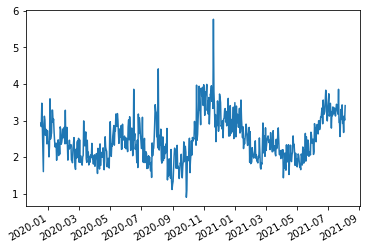

In [370]:
(agg_der/agg_spot)[-600:].plot()

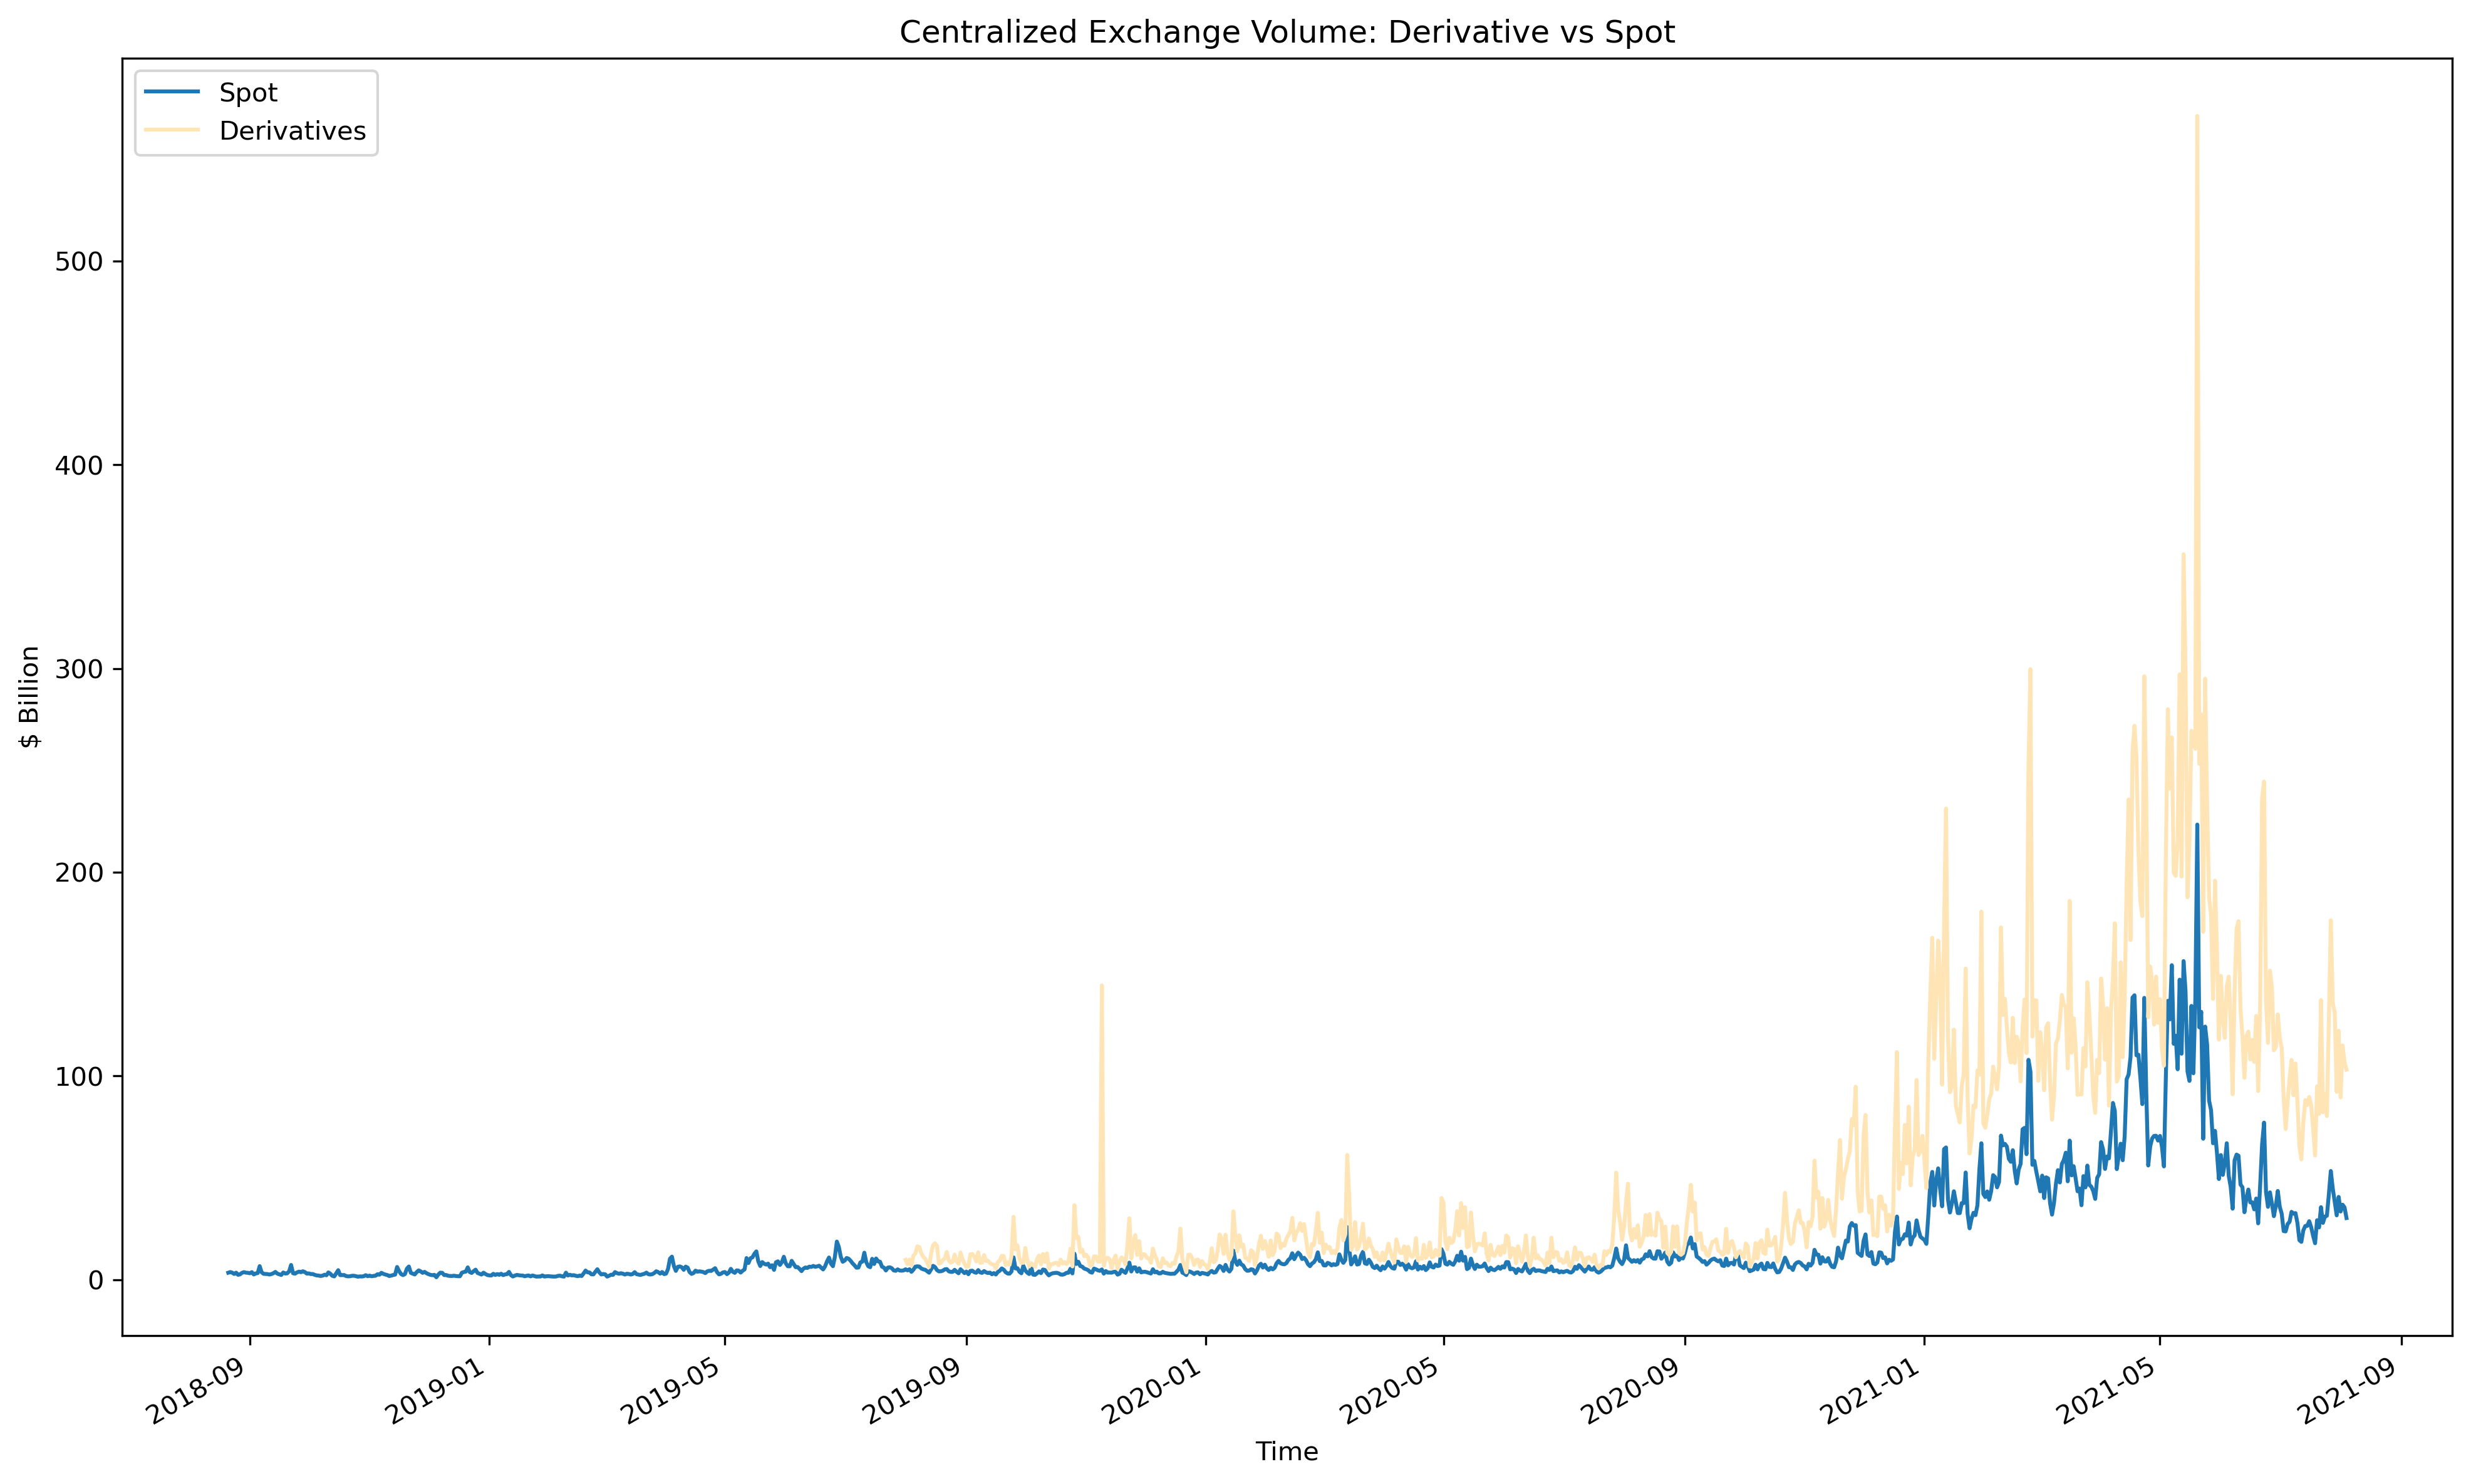

In [1381]:
plt.figure(figsize = (16, 10))
(spot_CEX_usd.sum(axis=1) / 1000000000).plot(title="Centralized Exchange Volume: Derivative vs Spot", linestyle = 'solid', label = "Spot")
(der_CEX_usd.sum(axis=1) / 1000000000).plot(title="Centralized Exchange Volume: Derivative vs Spot", linestyle = 'solid', label = "Derivatives", color = 'moccasin')
plt.xlabel("Time")
plt.ylabel("$ Billion")
plt.legend()
plt.savefig("Centralized Exchange Volume, Derivative vs Spot.pdf")

In [73]:
spot_CEX_usd[(spot_CEX_usd.index.year >= 2021) * (spot_CEX_usd.index.month <=6)].sum().sum() / 1000000000000

11.681284170680959

## Spot Market DEX

In [ ]:
## add exception for error 
## time of the last update 

df = {}

for i in range(len(spot_DEX)):
    df[i] = get_volume_cg(spot_DEX[i], days)

In [ ]:
volumes = df[0].combine_first(df[1])

for i in range(2, len(df)):
    volumes = volumes.combine_first(df[i])
    
spot_DEX_volume = volumes

In [78]:
relative_pct_spot = (spot_DEX_volume.sum(axis=1) / spot_CEX_volume.sum(axis=1))[-150:] * 100

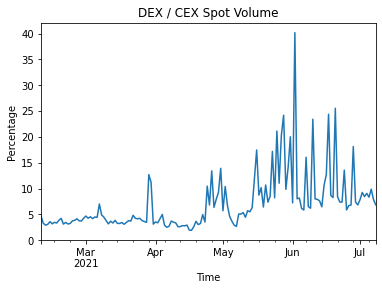

In [79]:
plt.figure()
relative_pct_spot.plot(title='DEX / CEX Spot Volume')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.show()

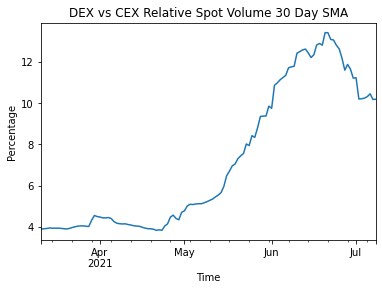

In [81]:
save_pdf(relative_pct_spot.rolling(window=30).mean()[30:], title='DEX vs CEX Relative Spot Volume 30 Day SMA', xlabel='Time', ylabel='Percentage')

<AxesSubplot:>

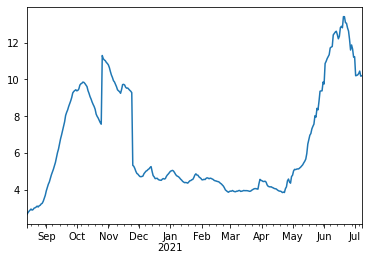

In [82]:
((spot_DEX_volume.sum(axis=1) / spot_CEX_volume.sum(axis=1)) * 100).rolling(window=30).mean()[30:].plot()